# **Quantization**

***Quantization is a technique to downsize a trained model so that we can deploy it on EDGE devices.*** In this tutorial, we will

1.   Train a handwritten digits model.
2.   Export to a disk and check the size of that model.
3.   Use two techniques for quantization: (1) Post-training Quantization and (2) Quantization Aware Training.

> [Deploy machine learning models on mobile and edge devices](https://www.tensorflow.org/lite)

> [Quantization in Deep Learning](https://www.youtube.com/watch?v=v1oHf1KV6kM)

In [1]:
# Import Library.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load Dataset.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print(len(X_train), len(X_test))

11501568/11490434 [==============================] - 0s 0us/step
60000 10000


In [2]:
print(X_train[0].shape, y_train[0])

(28, 28) 5


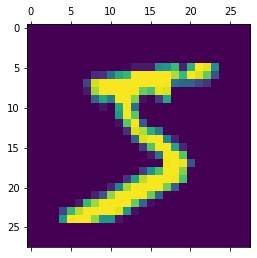

In [3]:
plt.matshow(X_train[0])

In [4]:
# Normalize the Feature Set.
X_train = X_train / 255
X_test = X_test / 255

X_train_flattened = X_train.reshape(len(X_train), 28 * 28)
X_test_flattened = X_test.reshape(len(X_test), 28 * 28)

print(X_train_flattened.shape, X_test_flattened.shape)

(60000, 784) (10000, 784)


In [5]:
# Model Building.

""" Using Flatten layer so that we don't have to call .reshape() on the input dataset. """
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Compile the Model.
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Fit the Model.
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2705 - accuracy: 0.9232
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1249 - accuracy: 0.9642
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0884 - accuracy: 0.9738
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0672 - accuracy: 0.9799
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0533 - accuracy: 0.9838
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0431 - accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0345 - accuracy: 0.9893
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0273 - accuracy: 0.9916
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0224 - accuracy: 0.9930
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.019

In [6]:
# Evaluate the Model.
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9774


[0.08280116319656372, 0.977400004863739]

In [7]:
# Save the Model.
model.save("tfmodel.h5")

# **Post Training Quantization**

> [**Blog**](https://www.tensorflow.org/model_optimization/guide/quantization/post_training)

> [**tf.lite.TFLiteConverter**](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter)

In [8]:
model = tf.keras.models.load_model("tfmodel.h5")

In [ ]:
# Without Quantization.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [10]:
print(len(tflite_model))

319784


In [11]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# With Quantization.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [13]:
print(len(tflite_quant_model))

84752


In [14]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once we have the above files saved to a disk, check the sizes. We can see that the quantized model is $1/4^{th}$ the size of a non-quantized model.

# **Quantization Aware Training**

> [**Website**](https://www.tensorflow.org/model_optimization/guide/quantization/training)

> [**Blog**](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)

In [ ]:
!pip install tensorflow_model_optimization

In [16]:
import tensorflow_model_optimization as tfmot
import warnings

warnings.filterwarnings("ignore")

quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

q_aware_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [17]:
q_aware_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0194 - accuracy: 0.9942
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0146 - accuracy: 0.9954
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0094 - accuracy: 0.9973
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0112 - accuracy: 0.9963
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0075 - accuracy: 0.9980
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - accuracy: 0.9973
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0073 - accuracy: 0.9978
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - accuracy: 0.9982
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0

In [18]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0978 - accuracy: 0.9787


[0.09775590151548386, 0.9786999821662903]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qaware_model = converter.convert()

In [20]:
print(len(tflite_qaware_model))

82472


In [21]:
with open("tflite_qaware_model.tflite", "wb") as f:
    f.write(tflite_qaware_model)